## Speed as Rhythm

### Regressions


In [37]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import glob
import numpy as np

from scipy.stats import normaltest
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.descriptivestats import sign_test
from scipy.stats import shapiro
from scipy.stats import skew
from scipy.stats import shapiro
from scipy.stats import kurtosis
from scipy.stats import boxcox
from scipy.stats import yeojohnson
from scipy.stats import wilcoxon
from scipy.stats import iqr
from scipy.stats import spearmanr
from scipy import stats
from scipy.stats import ttest_rel

sns.set(style="darkgrid")


In [38]:
def categorize_angles_into_quadrants(df, angle_column='angle_degrees', quadrant_column='quadrant'):
    """
    Transforms angles in degrees into quadrants (I, II, III, IV) and adds a 
    new column with the quadrant information to the DataFrame.

    Args:
        df: Pandas DataFrame containing an angle column.
        angle_column: Name of the column containing angles in degrees.  Defaults to 'angle_degrees'.
        quadrant_column: Name of the new column to store quadrant information. Defaults to 'quadrant'.

    Returns:
        Pandas DataFrame with the added quadrant column.  Returns the original DataFrame if the angle column is not found.
        Prints an error message if the angle column is not found.
    """

    if angle_column not in df.columns:
        print(f"Error: Angle column '{angle_column}' not found in DataFrame.")
        return df

    df[quadrant_column] = np.nan  # Initialize with NaN (for consistency with NaN angles)

    # Handle NaN angles directly
    nan_mask = df[angle_column].isna()

    # Vectorized operations for non-NaN angles
    valid_mask = ~nan_mask  # Invert the NaN mask

    angles = df.loc[valid_mask, angle_column].astype(float) % 360  # Vectorized modulo

    df.loc[valid_mask & (angles < 45), quadrant_column] = 'Ia'
    df.loc[valid_mask & (angles >= 45) & (angles < 90), quadrant_column] = 'Ib'
    df.loc[valid_mask & (angles >= 90) & (angles < 135), quadrant_column] = 'IIa'
    df.loc[valid_mask & (angles >= 135) & (angles < 180), quadrant_column] = 'IIb'
    df.loc[valid_mask & (angles >= 180) & (angles < 225), quadrant_column] = 'IIIa'
    df.loc[valid_mask & (angles >= 225) & (angles < 270), quadrant_column] = 'IIIb'
    df.loc[valid_mask & (angles >= 270) & (angles < 315 ), quadrant_column] = 'IVa'
    df.loc[valid_mask & (angles >= 315), quadrant_column] = 'IVb'


    return df

In [39]:
def detect_flips(df, quadrant1_col, quadrant2_col, flip_col='flip_type'):
    """
    Detects horizontal, vertical, and double flips based on quadrant changes.

    Args:
        df: Pandas DataFrame containing two quadrant columns.
        quadrant1_col: Name of the first quadrant column.
        quadrant2_col: Name of the second quadrant column.
        flip_col: Name of the new column to store flip information. Defaults to 'flip_type'.

    Returns:
        Pandas DataFrame with the added flip_type column.  Returns original DataFrame if columns are not found.
        Prints error messages if columns are not found.
    """
    
    if quadrant1_col not in df.columns:
        print(f"Error: Quadrant column '{quadrant1_col}' not found in DataFrame.")
        return df

    if quadrant2_col not in df.columns:
        print(f"Error: Quadrant column '{quadrant2_col}' not found in DataFrame.")
        return df

    df[flip_col] = 'N'  # Initialize

    # Create boolean masks for each flip type (vectorized)
    h_mask = ((df[quadrant1_col] == 'Ia') & (df[quadrant2_col] == 'IIa')) | \
             ((df[quadrant1_col] == 'IIa') & (df[quadrant2_col] == 'Ia')) | \
             ((df[quadrant1_col] == 'IIIa') & (df[quadrant2_col] == 'IVa')) | \
             ((df[quadrant1_col] == 'IVa') & (df[quadrant2_col] == 'IIIa')) | \
             ((df[quadrant1_col] == 'Ib') & (df[quadrant2_col] == 'IIb')) | \
             ((df[quadrant1_col] == 'IIb') & (df[quadrant2_col] == 'Ib')) | \
             ((df[quadrant1_col] == 'IIIb') & (df[quadrant2_col] == 'IVb')) | \
             ((df[quadrant1_col] == 'IVb') & (df[quadrant2_col] == 'IIIb')) | \
             ((df[quadrant1_col] == 'Ia') & (df[quadrant2_col] == 'IIb')) | \
             ((df[quadrant1_col] == 'IIb') & (df[quadrant2_col] == 'Ia')) | \
             ((df[quadrant1_col] == 'IIIa') & (df[quadrant2_col] == 'IVb')) | \
             ((df[quadrant1_col] == 'IVb') & (df[quadrant2_col] == 'IIIa')) | \
             ((df[quadrant1_col] == 'Ib') & (df[quadrant2_col] == 'IIa')) | \
             ((df[quadrant1_col] == 'IIa') & (df[quadrant2_col] == 'Ib')) | \
             ((df[quadrant1_col] == 'IIIb') & (df[quadrant2_col] == 'IVa')) | \
             ((df[quadrant1_col] == 'IVa') & (df[quadrant2_col] == 'IIIb'))

    v_mask = ((df[quadrant1_col] == 'Ia') & (df[quadrant2_col] == 'IVa')) | \
             ((df[quadrant1_col] == 'IVa') & (df[quadrant2_col] == 'Ia')) | \
             ((df[quadrant1_col] == 'IIa') & (df[quadrant2_col] == 'IIIa')) | \
             ((df[quadrant1_col] == 'IIIa') & (df[quadrant2_col] == 'IIa')) | \
             ((df[quadrant1_col] == 'Ib') & (df[quadrant2_col] == 'IVb')) | \
             ((df[quadrant1_col] == 'IVb') & (df[quadrant2_col] == 'Ib')) | \
             ((df[quadrant1_col] == 'IIb') & (df[quadrant2_col] == 'IIIb')) | \
             ((df[quadrant1_col] == 'IIIb') & (df[quadrant2_col] == 'IIb')) | \
             ((df[quadrant1_col] == 'Ia') & (df[quadrant2_col] == 'IVb')) | \
             ((df[quadrant1_col] == 'IVb') & (df[quadrant2_col] == 'Ia')) | \
             ((df[quadrant1_col] == 'IIa') & (df[quadrant2_col] == 'IIIb')) | \
             ((df[quadrant1_col] == 'IIIb') & (df[quadrant2_col] == 'IIa')) | \
             ((df[quadrant1_col] == 'Ib') & (df[quadrant2_col] == 'IVa')) | \
             ((df[quadrant1_col] == 'IVa') & (df[quadrant2_col] == 'Ib')) | \
             ((df[quadrant1_col] == 'IIb') & (df[quadrant2_col] == 'IIIa')) | \
             ((df[quadrant1_col] == 'IIIa') & (df[quadrant2_col] == 'IIb'))

    b_mask = ((df[quadrant1_col] == 'Ia') & (df[quadrant2_col] == 'IIIa')) | \
             ((df[quadrant1_col] == 'IIIa') & (df[quadrant2_col] == 'Ia')) | \
             ((df[quadrant1_col] == 'IIa') & (df[quadrant2_col] == 'IVa')) | \
             ((df[quadrant1_col] == 'IVa') & (df[quadrant2_col] == 'IIa')) | \
             ((df[quadrant1_col] == 'Ib') & (df[quadrant2_col] == 'III')) | \
             ((df[quadrant1_col] == 'IIIb') & (df[quadrant2_col] == 'Ib')) | \
             ((df[quadrant1_col] == 'IIb') & (df[quadrant2_col] == 'IVb')) | \
             ((df[quadrant1_col] == 'IVb') & (df[quadrant2_col] == 'IIb')) | \
             ((df[quadrant1_col] == 'Ia') & (df[quadrant2_col] == 'IIIVb')) | \
             ((df[quadrant1_col] == 'IIIb') & (df[quadrant2_col] == 'Ia')) | \
             ((df[quadrant1_col] == 'IIa') & (df[quadrant2_col] == 'IVb')) | \
             ((df[quadrant1_col] == 'IVb') & (df[quadrant2_col] == 'IIa')) | \
             ((df[quadrant1_col] == 'Ib') & (df[quadrant2_col] == 'IIIa')) | \
             ((df[quadrant1_col] == 'IIIa') & (df[quadrant2_col] == 'Ib')) | \
             ((df[quadrant1_col] == 'IIb') & (df[quadrant2_col] == 'IVa')) | \
             ((df[quadrant1_col] == 'IVa') & (df[quadrant2_col] == 'IIb'))

    same_mask = df[quadrant1_col] == df[quadrant2_col]

    nan_mask = df[quadrant1_col].isna() | df[quadrant2_col].isna()

    # Apply masks (vectorized)
    df.loc[h_mask, flip_col] = 'H'
    df.loc[v_mask, flip_col] = 'V'
    df.loc[b_mask, flip_col] = 'B'
    df.loc[same_mask, flip_col] = 'N' # No flip if same
    df.loc[nan_mask, flip_col] = np.nan # NaN if any is NaN

    return df

# Task a
Read all participants' data for task **a**. Add a column with participant number.

In [40]:
df = pd.DataFrame()
NPart = 0
for f in glob.glob('./SpeedAsRhythm/Partecipante??_a*.csv'):
    part = pd.read_csv(f)
    npart = int(f[28:30])
    part['nPart'] = npart
    NPart+=1
    df = pd.concat([df, part])
df = df.sort_values(by='nPart', ascending=True)
df.tail()
print(len(df))
print("number of participants = %3d" % NPart)

800
number of participants =  20


In [41]:
# rename the columns
df.columns = ['trial', 'soundSpeed', 'soundAngle', 'movSpeed', 'movAngle', 'soundStart', 'startDragTime', 'endDragTime', 'hInterval', 'vInterval', 'nPart']

In [42]:
# determine quadrant for sound (stimulus) and for movement (response)
categorize_angles_into_quadrants(df, angle_column='soundAngle', quadrant_column='soundQuadrant');
categorize_angles_into_quadrants(df, angle_column='movAngle', quadrant_column='movQuadrant');
detect_flips(df, 'soundQuadrant', 'movQuadrant', 'flip')
df['speed_diff'] = np.where(df['soundQuadrant'] == df['movQuadrant'], df['soundSpeed'] - df['movSpeed'], np.nan)
df['angle_diff'] = np.where(df['soundQuadrant'] == df['movQuadrant'], df['soundAngle'] - df['movAngle'], np.nan)
display(df)
dfExpA = df
groupA_secondo = df[df['nPart'] % 2 == 0]
groupA_primo = df[df['nPart'] % 2 != 0]

,trial,soundSpeed,soundAngle,movSpeed,movAngle,soundStart,startDragTime,endDragTime,hInterval,vInterval,nPart,soundQuadrant,movQuadrant,flip,speed_diff,angle_diff
19,19,37.684478,304.816029,15.552421,335.947471,1740393556366,1740393576186,1740393588649,1394.330718,969.663711,1,IVa,IVb,N,NaN,NaN
24,24,28.267477,317.873231,27.334524,319.398705,1740393650899,1740393658815,1740393665898,1430.961216,1582.189494,1,IVb,IVb,N,0.932953,-1.525474
25,25,33.835866,126.027625,41.138586,168.690068,1740393670399,1740393680921,1740393685631,1507.430202,1096.322995,1,IIa,IIb,N,NaN,NaN
26,26,72.207546,143.044079,60.287944,142.774601,1740393690131,1740393694073,1740393697281,519.922342,691.065773,1,IIb,IIb,N,11.919603,0.269479
27,27,30.696642,218.376044,52.092136,230.460213,1740393701782,1740393706405,1740393710114,1246.637830,1574.217141,1,IIIa,IIIb,N,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,15,69.507615,139.441469,80.513627,157.813322,1741191824491,1741191831856,1741191834257,568.097221,663.782094,20,IIb,IIb,N,-11.006012,-18.371853
16,16,76.032558,302.148626,89.727006,288.248924,1741191838758,1741191845085,1741191847256,741.505288,466.022798,20,IVa,IVa,N,-13.694449,13.899702
17,17,94.537060,77.109272,83.255622,81.164627,1741191851758,1741191854994,1741191857340,1422.441589,325.540360,20,Ib,Ib,N,11.281438,-4.055355
10,10,103.614743,282.027661,186.233377,274.596808,1741191766591,1741191769201,1741191770273,1389.426473,296.032861,20,IVa,IVa,N,-82.618633,7.430853


Show number and kind of flips per participant

Compute average number of flips per participant, of the different kinds. 


In [43]:
errors_df = df.groupby(['nPart', 'flip']).size().reset_index(name='Count')

# Create a pivot table to fill missing values with 0
pivot_table = errors_df.pivot_table(values='Count', index='nPart', columns='flip', aggfunc='sum', fill_value=0)

means = pivot_table.mean()
print("means = ")
print(means)

stds = pivot_table.std()
print("std = ")
print(stds)


means = 
flip
B     0.1
H     0.2
N    38.1
V     1.6
dtype: float64
std = 
flip
B    0.307794
H    0.523148
N    1.447321
V    1.231174
dtype: float64


In [44]:
dfN = df.loc[df['flip'] == 'N']
print("number of flips = %2d" % (len(df) - len(dfN)))

number of flips = 38


In [45]:
dfN.tail()

,trial,soundSpeed,soundAngle,movSpeed,movAngle,soundStart,startDragTime,endDragTime,hInterval,vInterval,nPart,soundQuadrant,movQuadrant,flip,speed_diff,angle_diff
14,14,94.444180,77.813256,76.405201,84.699073,1741191813808,1741191817440,1741191819990,1504.736993,324.971254,20,Ib,Ib,N,18.038979,-6.885817
15,15,69.507615,139.441469,80.513627,157.813322,1741191824491,1741191831856,1741191834257,568.097221,663.782094,20,IIb,IIb,N,-11.006012,-18.371853
16,16,76.032558,302.148626,89.727006,288.248924,1741191838758,1741191845085,1741191847256,741.505288,466.022798,20,IVa,IVa,N,-13.694449,13.899702
17,17,94.537060,77.109272,83.255622,81.164627,1741191851758,1741191854994,1741191857340,1422.441589,325.540360,20,Ib,Ib,N,11.281438,-4.055355
10,10,103.614743,282.027661,186.233377,274.596808,1741191766591,1741191769201,1741191770273,1389.426473,296.032861,20,IVa,IVa,N,-82.618633,7.430853


Spearman Rho: 0.14213325867861143
octant  0 P-value: 0.16944453648893198
Spearman Rho: -0.40102863497358915
octant  1 P-value: 1.5503073856375484e-05
Spearman Rho: 0.07255411255411254
octant  2 P-value: 0.475426728879651
Spearman Rho: -0.20208289501367555
octant  3 P-value: 0.04714284333650778
Spearman Rho: 0.06329880789525114
octant  4 P-value: 0.5649376373242456
Spearman Rho: -0.2475247524752475
octant  5 P-value: 0.013031992234344758
Spearman Rho: 0.2788073908174692
octant  6 P-value: 0.006219484056764993
Spearman Rho: -0.15510279600787974
octant  7 P-value: 0.16410730542515872
Spearman Rho errAngle A: -0.2071040005459058
P-value errAngle A: 7.914964915519552e-09


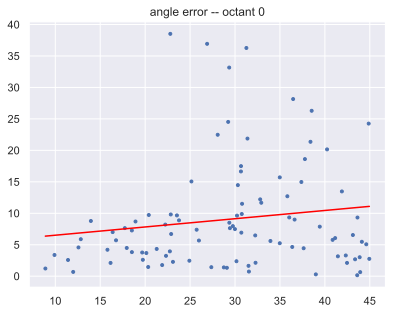

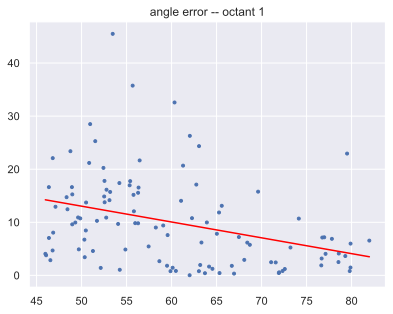

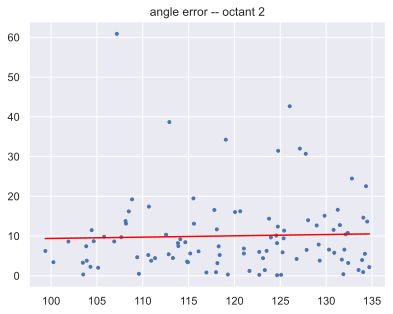

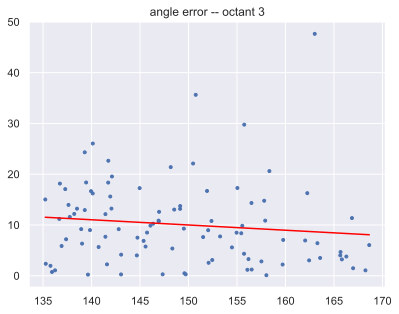

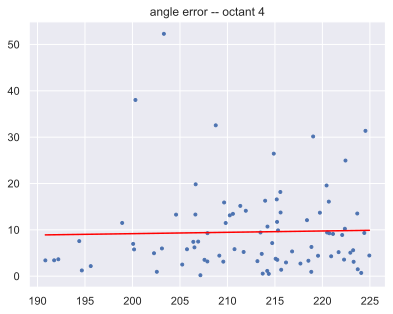

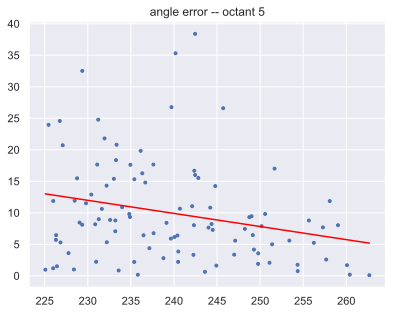

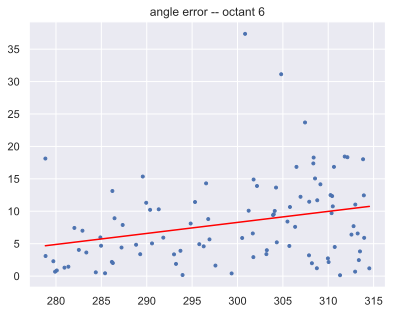

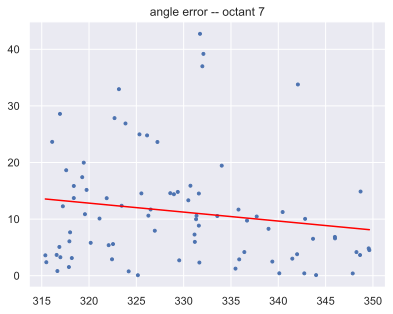

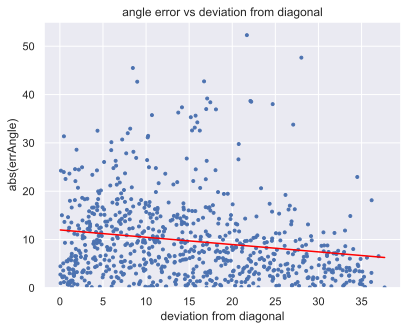

In [77]:
#Regression of angle error vs stimulus angle: 

dfnOct = []
dfnOct.append(dfN[dfN['soundQuadrant'] == 'Ia'].copy())
dfnOct.append(dfN[dfN['soundQuadrant'] == 'Ib'].copy())
dfnOct.append(dfN[dfN['soundQuadrant'] == 'IIa'].copy())
dfnOct.append(dfN[dfN['soundQuadrant'] == 'IIb'].copy())
dfnOct.append(dfN[dfN['soundQuadrant'] == 'IIIa'].copy())
dfnOct.append(dfN[dfN['soundQuadrant'] == 'IIIb'].copy())
dfnOct.append(dfN[dfN['soundQuadrant'] == 'IVa'].copy())
dfnOct.append(dfN[dfN['soundQuadrant'] == 'IVb'].copy())

for i in range(8):
    #Test Rho Spearman 
    corr, pvalue = spearmanr(dfnOct[i].soundAngle, abs(dfnOct[i].movAngle - dfnOct[i].soundAngle))
    print("Spearman Rho:", corr)
    print("octant ", i, "P-value:", pvalue)
    slope, intercept = np.polyfit(dfnOct[i].soundAngle, abs(dfnOct[i].movAngle - dfnOct[i].soundAngle), 1)
    x_fit = np.linspace(min(dfnOct[i].soundAngle), max(dfnOct[i].soundAngle), 100)
    y_fit = slope * x_fit + intercept
    fig, ax = plt.subplots()
    ax.plot(abs(dfnOct[i].soundAngle), abs(dfnOct[i].movAngle-dfnOct[i].soundAngle), '.')
    ax.plot(x_fit, y_fit, color='red')
    ax.set_title('angle error -- octant %d' %i);

#Overall regression in all octants
slope, intercept = np.polyfit(abs((dfN.soundAngle%90)-45), abs(dfN.movAngle - dfN.soundAngle), 1)
x_fit = np.linspace(min(abs((dfN.soundAngle%90)-45)), max(abs((dfN.soundAngle%90)-45)), 100)
y_fit = slope * x_fit + intercept

#Test Rho Spearman (0°-360°)
corr, pvalue = spearmanr(abs((dfN.soundAngle%90)-45), abs(dfN.movAngle - dfN.soundAngle))
print("Spearman Rho errAngle A:", corr)
print("P-value errAngle A:", pvalue)

fig, ax = plt.subplots()
ax.plot(abs((dfN.soundAngle%90)-45), abs(dfN.movAngle-dfN.soundAngle), '.')
ax.plot(x_fit, y_fit, color='red')
ax.set_ylim(0, 55)
ax.set_xlabel("deviation from diagonal")
ax.set_ylabel("abs(errAngle)")
ax.set_title('angle error vs deviation from diagonal');


Spearman Rho: -0.15051791713325868
octant  0 P-value: 0.14540517693216076
Spearman Rho: 0.09361504957835234
octant  1 P-value: 0.33292941585421953
Spearman Rho: -0.11778602350030921
octant  2 P-value: 0.24559351845123026
Spearman Rho: 0.22538396802019775
octant  3 P-value: 0.02644316159956357
Spearman Rho: -0.08485440687903069
octant  4 P-value: 0.4400375989434163
Spearman Rho: 0.30966696669666965
octant  5 P-value: 0.0017174829239850486
Spearman Rho: -0.13009518477043674
octant  6 P-value: 0.20890842210735222
Spearman Rho: 0.1546674502889607
octant  7 P-value: 0.1653087099198945
Spearman Rho errAngle A: 0.15361667809462548
P-value errAngle A: 2.0549994861222143e-05
Spearman Rho errSpeed A no bias: 0.2721590580933619
P-value errSpeed A no bias: 2.0859972186712077e-14
Spearman Rho errSpeed A signed: 0.13819386303218745
P-value errSpeed A signed: 0.00012978582500823931


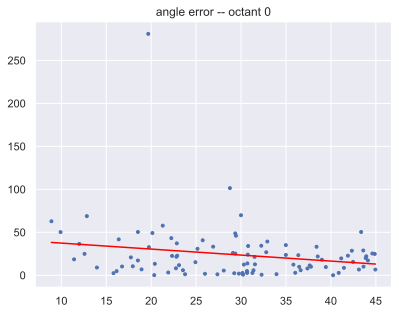

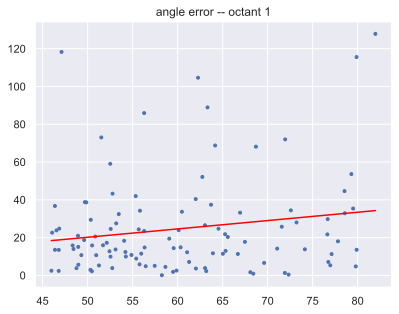

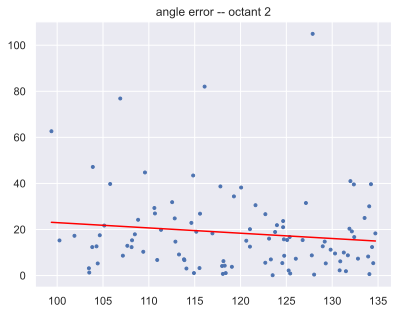

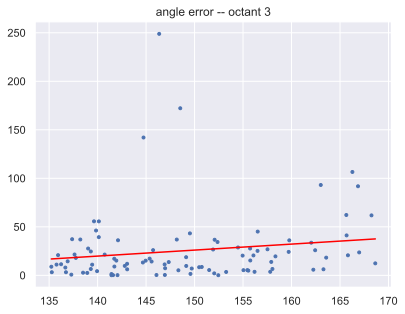

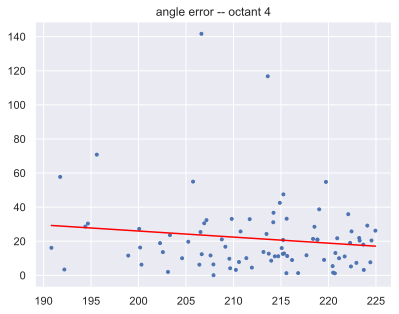

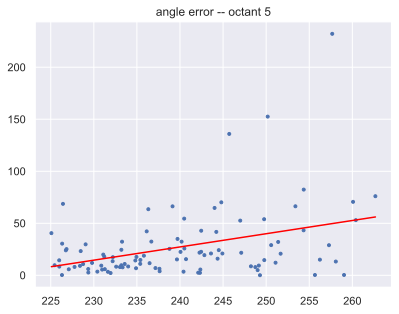

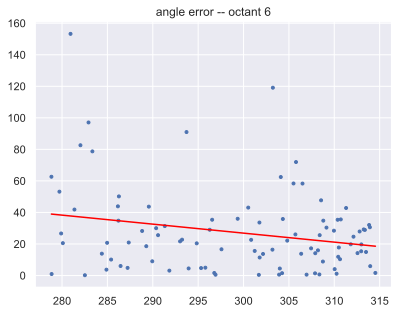

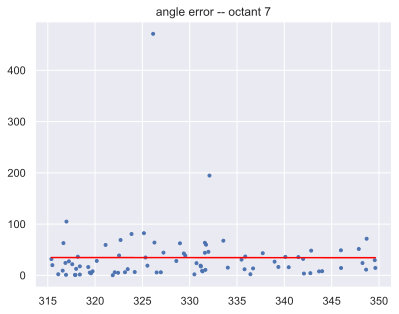

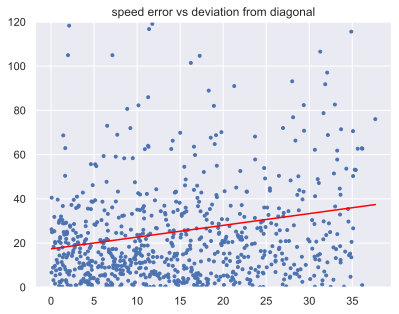

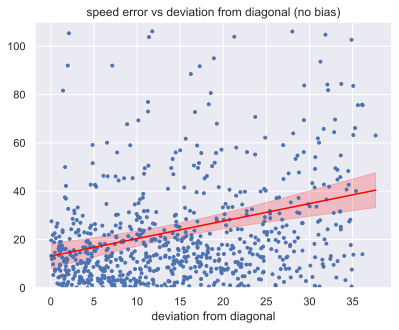

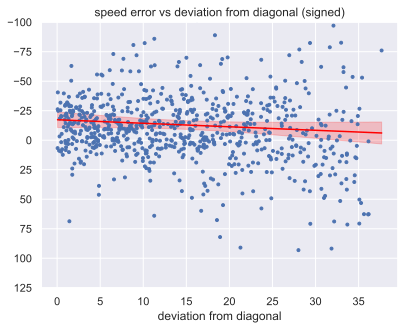

In [82]:
for i in range(8):
    #Test Rho Spearman 
    corr, pvalue = spearmanr(dfnOct[i].soundAngle, abs(dfnOct[i].soundSpeed - dfnOct[i].movSpeed))
    print("Spearman Rho:", corr)
    print("octant ", i, "P-value:", pvalue)
    slope, intercept = np.polyfit(dfnOct[i].soundAngle, abs(dfnOct[i].soundSpeed - dfnOct[i].movSpeed), 1)
    x_fit = np.linspace(min(dfnOct[i].soundAngle), max(dfnOct[i].soundAngle), 100)
    y_fit = slope * x_fit + intercept
    fig, ax = plt.subplots()
    ax.plot(abs(dfnOct[i].soundAngle), abs(dfnOct[i].soundSpeed-dfnOct[i].movSpeed), '.')
    ax.plot(x_fit, y_fit, color='red')
    ax.set_title('speed error -- octant %d' %i);

#Overall regression in all octants
slope, intercept = np.polyfit(abs((dfN.soundAngle%90)-45), abs(dfN.soundSpeed - dfN.movSpeed), 1)
x_fit = np.linspace(min(abs((dfN.soundAngle%90)-45)), max(abs((dfN.soundAngle%90)-45)), 100)
y_fit = slope * x_fit + intercept

fig, ax = plt.subplots()
ax.plot(abs((dfN.soundAngle%90)-45), abs(dfN.soundSpeed-dfN.movSpeed), '.') 
ax.plot(x_fit, y_fit, color='red')
ax.set_ylim(0, 120)
ax.set_title('speed error vs deviation from diagonal');

#Overall regression, no bias
slope, intercept = np.polyfit(abs((dfN.soundAngle%90)-45), abs(dfN.soundSpeed - dfN.movSpeed-np.mean(errSpeed)), 1)
x_fit = np.linspace(min(abs((dfN.soundAngle%90)-45)), max(abs((dfN.soundAngle%90)-45)), 100)
y_fit = slope * x_fit + intercept


#Test Rho Spearman (0°-360°)
corr, pvalue = spearmanr(abs((dfN.soundAngle%90)-45), abs(dfN.soundSpeed - dfN.movSpeed))
print("Spearman Rho errAngle A:", corr)
print("P-value errAngle A:", pvalue)

#Test Rho Spearman (0°-360°) no bias
corr, pvalue = spearmanr(abs((dfN.soundAngle%90)-45), abs(dfN.soundSpeed - dfN.movSpeed - np.mean(errSpeed)))
print("Spearman Rho errSpeed A no bias:", corr)
print("P-value errSpeed A no bias:", pvalue)

#Test Rho Spearman (0°-360°) signed
corr, pvalue = spearmanr(abs((dfN.soundAngle%90)-45), (dfN.soundSpeed - dfN.movSpeed))
print("Spearman Rho errSpeed A signed:", corr)
print("P-value errSpeed A signed:", pvalue)


# 99% confidence interval
x = abs((dfN.soundAngle % 90) - 45)
y = abs(dfN.soundSpeed - dfN.movSpeed - np.mean(errSpeed))
n = len(x)
t_val = stats.t.ppf(0.995, n - 2)
y_pred = slope * x + intercept
residuals = y - y_pred
s_err = np.sqrt(np.sum(residuals**2) / (n - 2))
ci = t_val * s_err * np.sqrt(1/n + (x_fit - np.mean(x))**2 / np.sum((x - np.mean(x))**2))

# Plot
fig, ax = plt.subplots()
ax.plot(x, y, '.') #, label="Data")
ax.plot(x_fit, y_fit, color='red') #, label="Regression")
ax.fill_between(x_fit, y_fit - ci, y_fit + ci, color='red', alpha=0.2) #, label="IC 99%")
ax.set_ylim(0, 110)
ax.set_xlabel("deviation from diagonal")
# ax.set_ylabel("abs(errSpeed-bias)")
ax.set_title('speed error vs deviation from diagonal (no bias)')
# ax.legend()

# Overall regression, no sign
slope, intercept = np.polyfit(abs((dfN.soundAngle%90)-45), (dfN.soundSpeed - dfN.movSpeed), 1)
x_fit = np.linspace(min(abs((dfN.soundAngle%90)-45)), max(abs((dfN.soundAngle%90)-45)), 100)
y_fit = slope * x_fit + intercept

# 99% confidence interval
y = dfN.soundSpeed - dfN.movSpeed
y_pred = slope * x + intercept
residuals = y - y_pred
s_err = np.sqrt(np.sum(residuals**2) / (n - 2))
ci = t_val * s_err * np.sqrt(1/n + (x_fit - np.mean(x))**2 / np.sum((x - np.mean(x))**2))

# Plot
fig, ax = plt.subplots()
ax.plot(x, y, '.') #, label="Data")
ax.plot(x_fit, y_fit, color='red') #, label="Regression")
ax.fill_between(x_fit, y_fit - ci, y_fit + ci, color='red', alpha=0.2) #, label="IC 99%")
ax.set_ylim(125, -100)
ax.set_xlabel("deviation from diagonal")
# ax.set_ylabel("errSpeed")
ax.set_title('speed error vs deviation from diagonal (signed)')
# ax.legend()

plt.show()


analysis of relative speed error (percent error)

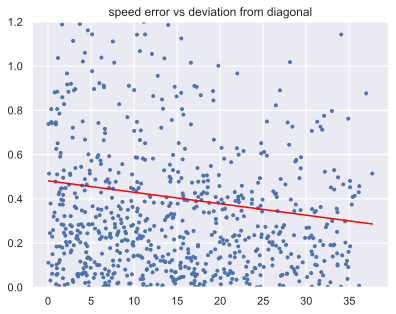

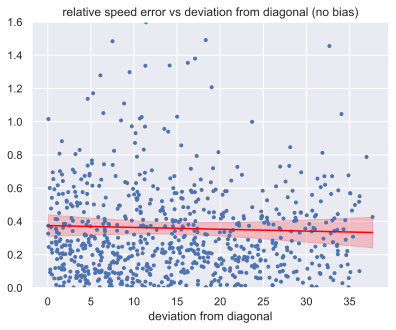

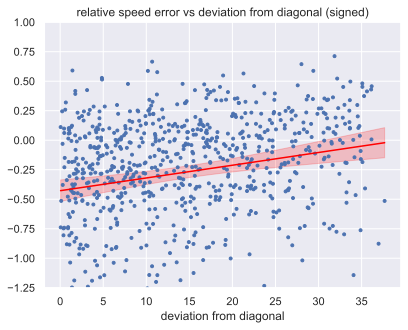

In [85]:
# Analysis of relative speed error (percent error)
slope, intercept = np.polyfit(abs((dfN.soundAngle%90)-45), abs(dfN.soundSpeed - dfN.movSpeed)/dfN.soundSpeed, 1)
x_fit = np.linspace(min(abs((dfN.soundAngle%90)-45)), max(abs((dfN.soundAngle%90)-45)), 100)
y_fit = slope * x_fit + intercept

fig, ax = plt.subplots()
ax.plot(abs((dfN.soundAngle%90)-45), abs(dfN.soundSpeed-dfN.movSpeed)/dfN.soundSpeed, '.') 
ax.plot(x_fit, y_fit, color='red')
ax.set_ylim(0, 1.2)
ax.set_title('speed error vs deviation from diagonal');

# no bias
slope, intercept = np.polyfit(abs((dfN.soundAngle%90)-45), abs(dfN.soundSpeed - dfN.movSpeed-np.mean(errSpeed))/dfN.soundSpeed, 1)
x_fit = np.linspace(min(abs((dfN.soundAngle%90)-45)), max(abs((dfN.soundAngle%90)-45)), 100)
y_fit = slope * x_fit + intercept

# 99% confidence interval
x = abs((dfN.soundAngle % 90) - 45)
y = abs(dfN.soundSpeed - dfN.movSpeed - np.mean(errSpeed))/dfN.soundSpeed
n = len(x)
t_val = stats.t.ppf(0.995, n - 2)
y_pred = slope * x + intercept
residuals = y - y_pred
s_err = np.sqrt(np.sum(residuals**2) / (n - 2))
ci = t_val * s_err * np.sqrt(1/n + (x_fit - np.mean(x))**2 / np.sum((x - np.mean(x))**2))

# Plot
fig, ax = plt.subplots()
ax.plot(x, y, '.') #, label="Data")
ax.plot(x_fit, y_fit, color='red') #, label="Regressione")
ax.fill_between(x_fit, y_fit - ci, y_fit + ci, color='red', alpha=0.2) #, label="IC 99%")
ax.set_ylim(0, 1.6)
ax.set_xlabel("deviation from diagonal")
# ax.set_ylabel("abs(errSpeed-bias)/soundSpeed")
ax.set_title('relative speed error vs deviation from diagonal (no bias)')
# ax.legend()

# signed
slope, intercept = np.polyfit(abs((dfN.soundAngle%90)-45), (dfN.soundSpeed - dfN.movSpeed)/dfN.soundSpeed, 1)
x_fit = np.linspace(min(abs((dfN.soundAngle%90)-45)), max(abs((dfN.soundAngle%90)-45)), 100)
y_fit = slope * x_fit + intercept

# 99% confidence interval
y = (dfN.soundSpeed - dfN.movSpeed)/dfN.soundSpeed
y_pred = slope * x + intercept
residuals = y - y_pred
s_err = np.sqrt(np.sum(residuals**2) / (n - 2))
ci = t_val * s_err * np.sqrt(1/n + (x_fit - np.mean(x))**2 / np.sum((x - np.mean(x))**2))

# Plot
fig, ax = plt.subplots()
ax.plot(x, y, '.') #, label="Data")
ax.plot(x_fit, y_fit, color='red') #, label="Regression")
ax.fill_between(x_fit, y_fit - ci, y_fit + ci, color='red', alpha=0.2) #, label="IC 99%")
ax.set_ylim(-1.25, 1)
ax.set_xlabel("deviation from diagonal")
#ax.set_ylabel("errSpeed/soundSpeed")
ax.set_title('relative speed error vs deviation from diagonal (signed)')
# ax.legend()

plt.show()

# Task b
Read all participants' data for task **b**. Add a column with participant number.

In [92]:
df = pd.DataFrame()
NPart = 0
for f in glob.glob('./SpeedAsRhythm/Partecipante??_b*.csv'):
    part = pd.read_csv(f)
    npart = int(f[28:30])
    part['nPart'] = npart
    NPart+=1
    df = pd.concat([df, part])
df = df.sort_values(by='nPart', ascending=True)
df.tail()
print(len(df))
print("number of participants = %3d" % NPart)

800
number of participants =  20


In [93]:
# rename the columns
df.columns = ['trial', 'movSpeed', 'movAngle', 'tapSpeed', 'tapAngle', 'movStart', 'tapHor', 'tapVer', 'tapHor2', 'tapVer2', 'hInterval', 'vInterval', 'nPart']

In [94]:
# determine quadrant for sound (stimulus) and for movement (response)
categorize_angles_into_quadrants(df, angle_column='movAngle', quadrant_column='movQuadrant');
categorize_angles_into_quadrants(df, angle_column='tapAngle', quadrant_column='tapQuadrant');
detect_flips(df, 'movQuadrant', 'tapQuadrant', 'flip')
df['speed_diff'] = np.where(df['tapQuadrant'] == df['movQuadrant'],  df['movSpeed'] - df['tapSpeed'], np.nan)
df['angle_diff'] = np.where(df['tapQuadrant'] == df['movQuadrant'],  df['movAngle'] - df['tapAngle'], np.nan)
display(df)
dfExpB = df
groupB_secondo = df[df['nPart'] % 2 != 0]
groupB_primo = df[df['nPart'] % 2 == 0]

,trial,movSpeed,movAngle,tapSpeed,tapAngle,movStart,tapHor,tapVer,tapHor2,tapVer2,hInterval,vInterval,nPart,movQuadrant,tapQuadrant,flip,speed_diff,angle_diff
38,38,29.069538,139.792341,18.510638,148.937093,1740394576071,1740394590426,1740394584867,1740394592318,1740394588008,1351.309406,1598.625247,1,IIb,IIb,N,10.558899,-9.144751
15,15,47.295864,154.388125,30.871862,127.869972,1740394327691,1740394330588,1740394334477,1740394332171,1740394335708,703.421001,1467.372329,1,IIb,IIa,N,NaN,NaN
14,14,31.558088,134.454512,36.150549,133.707467,1740394315892,1740394322676,1740394319730,1740394323877,1740394320878,1357.375186,1331.772242,1,IIa,IIa,N,-4.592461,0.747046
13,13,77.480473,342.555969,67.151947,340.139432,1740394306524,1740394308565,1740394310764,1740394309040,1740394312079,405.859724,1291.620691,1,IVb,IVb,N,10.328526,2.416537
12,12,32.529874,42.008159,26.163425,44.258234,1740394295225,1740394301120,1740394298062,1740394302721,1740394299705,1241.140979,1378.032018,1,Ia,Ia,N,6.366448,-2.250075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14,14,138.820469,65.656067,109.941678,53.150256,1741191186673,1741191194739,1741191191888,1741191195194,1741191192229,524.259097,237.196171,20,Ib,Ib,N,28.878791,12.505811
15,15,74.018834,158.122704,51.863848,157.301473,1741191199007,1741191205837,1741191202797,1741191206464,1741191204296,436.755652,1087.709087,20,IIb,IIb,N,22.154986,0.821231
16,16,53.399478,317.429087,44.009027,336.737338,1741191210273,1741191218437,1741191214920,1741191219179,1741191216646,762.862920,830.452958,20,IVb,IVb,N,9.390451,-19.308251
9,9,92.749237,200.641512,36.119262,148.705422,1741191122743,1741191133175,1741191130539,1741191134147,1741191132138,345.641464,917.545167,20,IIIa,IIb,V,NaN,NaN


Show number and kind of flips per participant

Compute average number of flips per participant, of the different kinds. 


In [95]:
errors_df = df.groupby(['nPart', 'flip']).size().reset_index(name='Count')

# Create a pivot table to fill missing values with 0
pivot_table = errors_df.pivot_table(values='Count', index='nPart', columns='flip', aggfunc='sum', fill_value=0)

means = pivot_table.mean()
print("means = ")
print(means)

stds = pivot_table.std()
print("std = ")
print(stds)


means = 
flip
H     0.1
N    39.5
V     0.4
dtype: float64
std = 
flip
H    0.307794
N    0.827170
V    0.680557
dtype: float64


In [96]:
dfN = df.loc[df['flip'] == 'N']
print("number of flips = %2d" % (len(df) - len(dfN)))

number of flips = 10


In [97]:
dfN.tail()

,trial,movSpeed,movAngle,tapSpeed,tapAngle,movStart,tapHor,tapVer,tapHor2,tapVer2,hInterval,vInterval,nPart,movQuadrant,tapQuadrant,flip,speed_diff,angle_diff
13,13,64.367225,207.666240,34.939732,214.189027,1741191175307,1741191181820,1741191178495,1741191182858,1741191180023,526.242386,1003.780659,20,IIIa,IIIa,N,29.427493,-6.522787
14,14,138.820469,65.656067,109.941678,53.150256,1741191186673,1741191194739,1741191191888,1741191195194,1741191192229,524.259097,237.196171,20,Ib,Ib,N,28.878791,12.505811
15,15,74.018834,158.122704,51.863848,157.301473,1741191199007,1741191205837,1741191202797,1741191206464,1741191204296,436.755652,1087.709087,20,IIb,IIb,N,22.154986,0.821231
16,16,53.399478,317.429087,44.009027,336.737338,1741191210273,1741191218437,1741191214920,1741191219179,1741191216646,762.862920,830.452958,20,IVb,IVb,N,9.390451,-19.308251
39,39,56.230280,236.645440,43.161428,231.189298,1741191483474,1741191494304,1741191489578,1741191495413,1741191490470,970.357306,638.729173,20,IIIb,IIIb,N,13.068853,5.456142


Spearman Rho: -0.49559142702116116
octant  0 P-value: 2.838806275986974e-07
Spearman Rho: 0.4178726933443914
octant  1 P-value: 9.192010490832406e-06
Spearman Rho: -0.35431401836313314
octant  2 P-value: 0.00024077536886840987
Spearman Rho: 0.4464065230052417
octant  3 P-value: 2.8825072553903197e-06
Spearman Rho: -0.35873983739837395
octant  4 P-value: 0.0010066173845212575
Spearman Rho: 0.41963226114698765
octant  5 P-value: 3.129370439152822e-05
Spearman Rho: -0.2180909545227386
octant  6 P-value: 0.018679903512653237
Spearman Rho: 0.3572843190450353
octant  7 P-value: 0.0003522286385445676
Spearman Rho errAngle B: 0.3883067845796373
P-value errAngle B: 7.849651458634529e-30


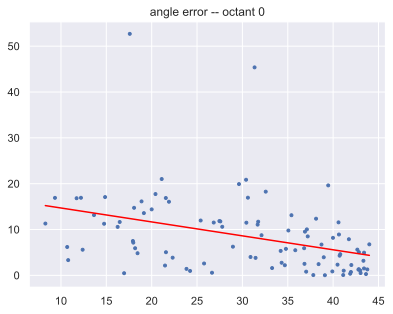

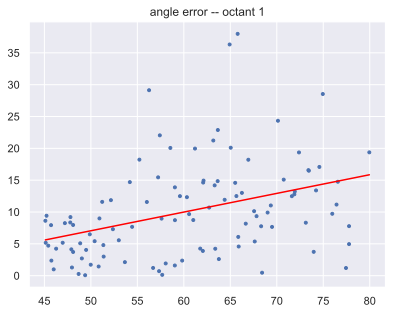

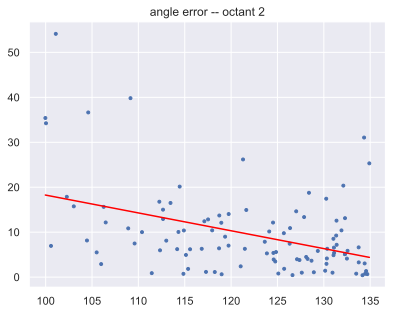

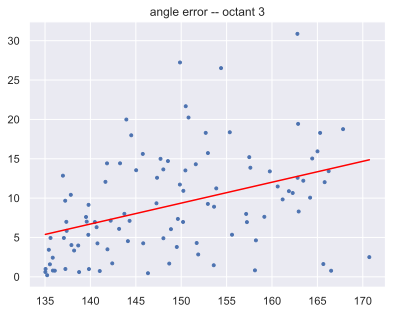

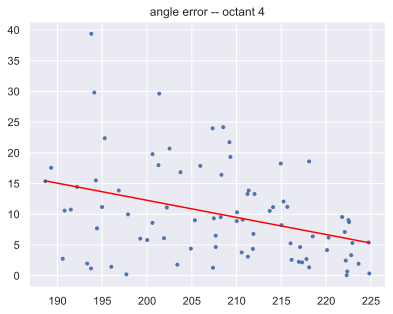

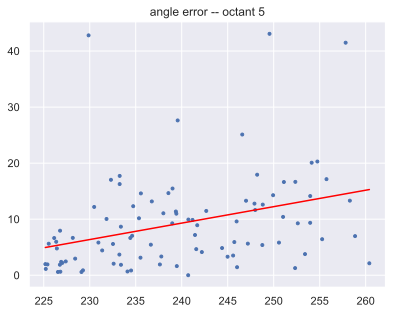

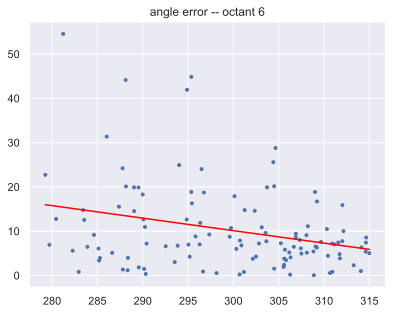

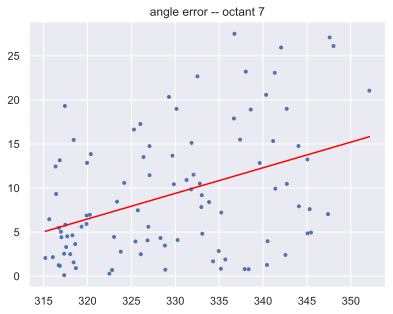

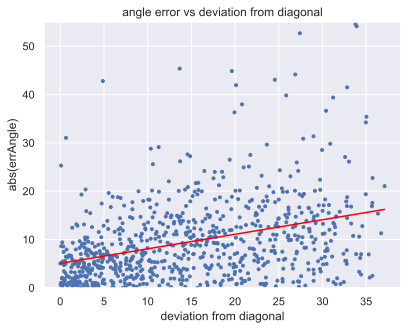

In [99]:
#Regression of angle error vs stimulus angle: 

dfnOct = []
dfnOct.append(dfN[dfN['movQuadrant'] == 'Ia'].copy())
dfnOct.append(dfN[dfN['movQuadrant'] == 'Ib'].copy())
dfnOct.append(dfN[dfN['movQuadrant'] == 'IIa'].copy())
dfnOct.append(dfN[dfN['movQuadrant'] == 'IIb'].copy())
dfnOct.append(dfN[dfN['movQuadrant'] == 'IIIa'].copy())
dfnOct.append(dfN[dfN['movQuadrant'] == 'IIIb'].copy())
dfnOct.append(dfN[dfN['movQuadrant'] == 'IVa'].copy())
dfnOct.append(dfN[dfN['movQuadrant'] == 'IVb'].copy())

for i in range(8):
    #Test Rho Spearman 
    corr, pvalue = spearmanr(dfnOct[i].movAngle, abs(dfnOct[i].tapAngle - dfnOct[i].movAngle))
    print("Spearman Rho:", corr)
    print("octant ", i, "P-value:", pvalue)
    slope, intercept = np.polyfit(dfnOct[i].movAngle, abs(dfnOct[i].tapAngle - dfnOct[i].movAngle), 1)
    x_fit = np.linspace(min(dfnOct[i].movAngle), max(dfnOct[i].movAngle), 100)
    y_fit = slope * x_fit + intercept
    fig, ax = plt.subplots()
    ax.plot(abs(dfnOct[i].movAngle), abs(dfnOct[i].tapAngle-dfnOct[i].movAngle), '.')
    ax.plot(x_fit, y_fit, color='red')
    ax.set_title('angle error -- octant %d' %i);

#Overall regression in all octants
slope, intercept = np.polyfit(abs((dfN.movAngle%90)-45), abs(dfN.tapAngle - dfN.movAngle), 1)
x_fit = np.linspace(min(abs((dfN.movAngle%90)-45)), max(abs((dfN.movAngle%90)-45)), 100)
y_fit = slope * x_fit + intercept

#Test Rho Spearman (0°-360°)
corr, pvalue = spearmanr(abs((dfN.movAngle%90)-45), abs(dfN.tapAngle - dfN.movAngle))
print("Spearman Rho errAngle B:", corr)
print("P-value errAngle B:", pvalue)

fig, ax = plt.subplots()
ax.plot(abs((dfN.movAngle%90)-45), abs(dfN.tapAngle-dfN.movAngle), '.')
ax.plot(x_fit, y_fit, color='red')
ax.set_ylim(0, 55)
ax.set_xlabel("deviation from diagonal")
ax.set_ylabel("abs(errAngle)")
ax.set_title('angle error vs deviation from diagonal');


Spearman Rho: -0.4609875203472599
octant  0 P-value: 2.283735196932718e-06
Spearman Rho: 0.35060128550694586
octant  1 P-value: 0.0002457093031598402
Spearman Rho: -0.42728331063568076
octant  2 P-value: 6.75333270475519e-06
Spearman Rho: 0.24786255096097842
octant  3 P-value: 0.012450582746954653
Spearman Rho: -0.571973803071364
octant  4 P-value: 2.4357211716055844e-08
Spearman Rho: 0.41534762572630735
octant  5 P-value: 3.8383049607018615e-05
Spearman Rho: -0.3072002460308308
octant  6 P-value: 0.0007956330179302024
Spearman Rho: 0.4771432447097124
octant  7 P-value: 8.876035262743968e-07
Spearman Rho errAngle A: 0.40228411911523043
P-value errAngle A: 4.350543394574453e-32
Spearman Rho errSpeed A no bias: 0.41678337668798526
P-value errSpeed A no bias: 1.5191145152531642e-34
Spearman Rho errSpeed A signed: 0.3336816876728479
P-value errSpeed A signed: 5.334525599406978e-22


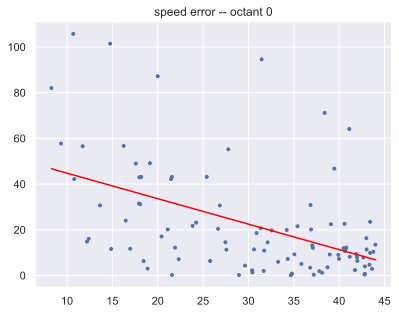

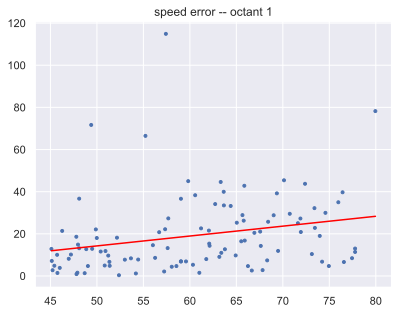

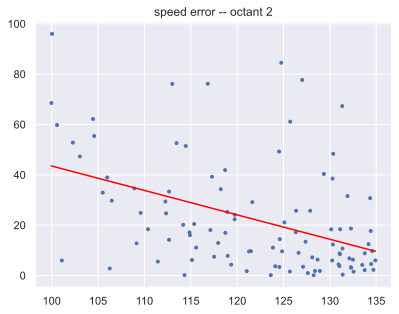

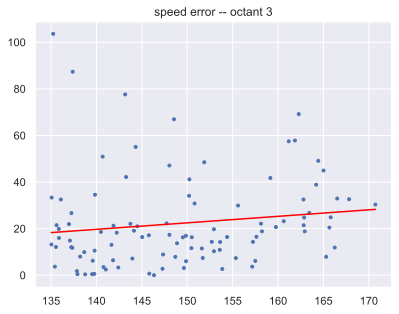

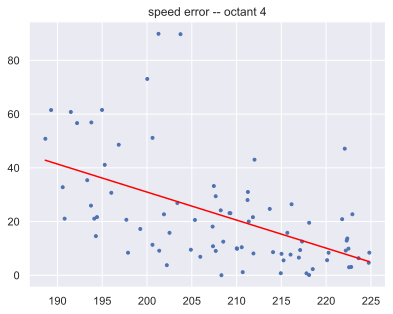

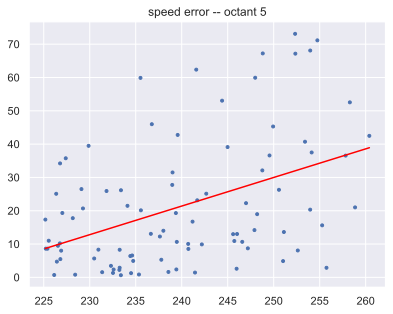

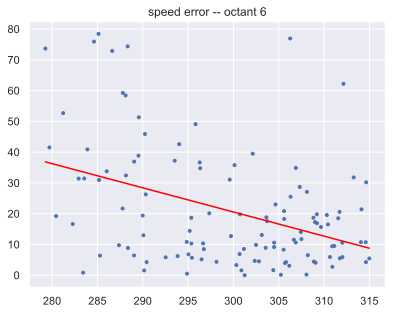

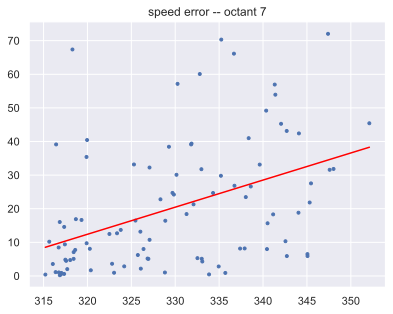

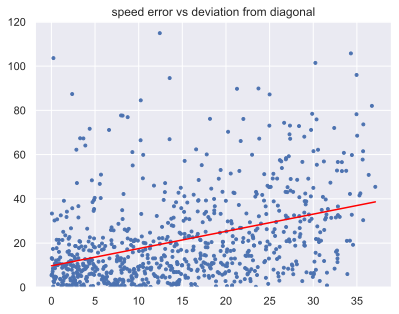

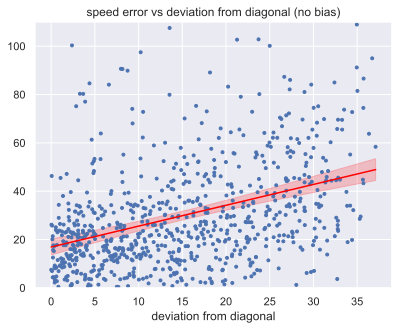

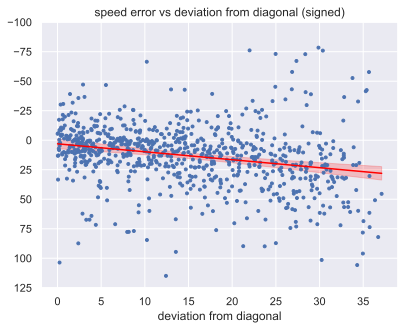

In [100]:
for i in range(8):
    #Test Rho Spearman 
    corr, pvalue = spearmanr(dfnOct[i].movAngle, abs(dfnOct[i].movSpeed - dfnOct[i].tapSpeed))
    print("Spearman Rho:", corr)
    print("octant ", i, "P-value:", pvalue)
    slope, intercept = np.polyfit(dfnOct[i].movAngle, abs(dfnOct[i].movSpeed - dfnOct[i].tapSpeed), 1)
    x_fit = np.linspace(min(dfnOct[i].movAngle), max(dfnOct[i].movAngle), 100)
    y_fit = slope * x_fit + intercept
    fig, ax = plt.subplots()
    ax.plot(abs(dfnOct[i].movAngle), abs(dfnOct[i].movSpeed-dfnOct[i].tapSpeed), '.')
    ax.plot(x_fit, y_fit, color='red')
    ax.set_title('speed error -- octant %d' %i);

#Overall regression in all octants
slope, intercept = np.polyfit(abs((dfN.movAngle%90)-45), abs(dfN.movSpeed - dfN.tapSpeed), 1)
x_fit = np.linspace(min(abs((dfN.movAngle%90)-45)), max(abs((dfN.movAngle%90)-45)), 100)
y_fit = slope * x_fit + intercept

fig, ax = plt.subplots()
ax.plot(abs((dfN.movAngle%90)-45), abs(dfN.movSpeed-dfN.tapSpeed), '.') 
ax.plot(x_fit, y_fit, color='red')
ax.set_ylim(0, 120)
ax.set_title('speed error vs deviation from diagonal');

#Overall regression, no bias
slope, intercept = np.polyfit(abs((dfN.movAngle%90)-45), abs(dfN.movSpeed - dfN.tapSpeed-np.mean(errSpeed)), 1)
x_fit = np.linspace(min(abs((dfN.movAngle%90)-45)), max(abs((dfN.movAngle%90)-45)), 100)
y_fit = slope * x_fit + intercept


#Test Rho Spearman (0°-360°)
corr, pvalue = spearmanr(abs((dfN.movAngle%90)-45), abs(dfN.movSpeed - dfN.tapSpeed))
print("Spearman Rho errAngle A:", corr)
print("P-value errAngle A:", pvalue)

#Test Rho Spearman (0°-360°) no bias
corr, pvalue = spearmanr(abs((dfN.movAngle%90)-45), abs(dfN.movSpeed - dfN.tapSpeed - np.mean(errSpeed)))
print("Spearman Rho errSpeed A no bias:", corr)
print("P-value errSpeed A no bias:", pvalue)

#Test Rho Spearman (0°-360°) signed
corr, pvalue = spearmanr(abs((dfN.movAngle%90)-45), (dfN.movSpeed - dfN.tapSpeed))
print("Spearman Rho errSpeed A signed:", corr)
print("P-value errSpeed A signed:", pvalue)


# 99% confidence interval
x = abs((dfN.movAngle % 90) - 45)
y = abs(dfN.movSpeed - dfN.tapSpeed - np.mean(errSpeed))
n = len(x)
t_val = stats.t.ppf(0.995, n - 2)
y_pred = slope * x + intercept
residuals = y - y_pred
s_err = np.sqrt(np.sum(residuals**2) / (n - 2))
ci = t_val * s_err * np.sqrt(1/n + (x_fit - np.mean(x))**2 / np.sum((x - np.mean(x))**2))

# Plot
fig, ax = plt.subplots()
ax.plot(x, y, '.') #, label="Data")
ax.plot(x_fit, y_fit, color='red') #, label="Regression")
ax.fill_between(x_fit, y_fit - ci, y_fit + ci, color='red', alpha=0.2) #, label="IC 99%")
ax.set_ylim(0, 110)
ax.set_xlabel("deviation from diagonal")
# ax.set_ylabel("abs(errSpeed-bias)")
ax.set_title('speed error vs deviation from diagonal (no bias)')
# ax.legend()

# Overall regression, no sign
slope, intercept = np.polyfit(abs((dfN.movAngle%90)-45), (dfN.movSpeed - dfN.tapSpeed), 1)
x_fit = np.linspace(min(abs((dfN.movAngle%90)-45)), max(abs((dfN.movAngle%90)-45)), 100)
y_fit = slope * x_fit + intercept

# 99% confidence interval
y = dfN.movSpeed - dfN.tapSpeed
y_pred = slope * x + intercept
residuals = y - y_pred
s_err = np.sqrt(np.sum(residuals**2) / (n - 2))
ci = t_val * s_err * np.sqrt(1/n + (x_fit - np.mean(x))**2 / np.sum((x - np.mean(x))**2))

# Plot
fig, ax = plt.subplots()
ax.plot(x, y, '.') #, label="Data")
ax.plot(x_fit, y_fit, color='red') #, label="Regression")
ax.fill_between(x_fit, y_fit - ci, y_fit + ci, color='red', alpha=0.2) #, label="IC 99%")
ax.set_ylim(125, -100)
ax.set_xlabel("deviation from diagonal")
# ax.set_ylabel("errSpeed")
ax.set_title('speed error vs deviation from diagonal (signed)')
# ax.legend()

plt.show()

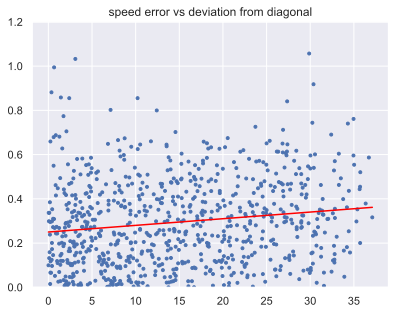

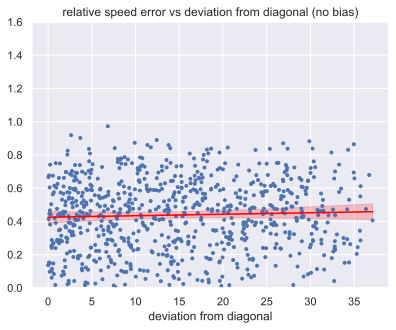

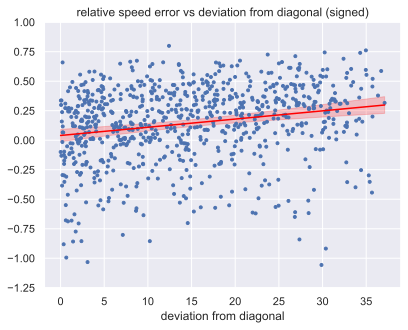

In [101]:
# Analysis of relative speed error (percent error)
slope, intercept = np.polyfit(abs((dfN.movAngle%90)-45), abs(dfN.movSpeed - dfN.tapSpeed)/dfN.movSpeed, 1)
x_fit = np.linspace(min(abs((dfN.movAngle%90)-45)), max(abs((dfN.movAngle%90)-45)), 100)
y_fit = slope * x_fit + intercept

fig, ax = plt.subplots()
ax.plot(abs((dfN.movAngle%90)-45), abs(dfN.movSpeed-dfN.tapSpeed)/dfN.movSpeed, '.') 
ax.plot(x_fit, y_fit, color='red')
ax.set_ylim(0, 1.2)
ax.set_title('speed error vs deviation from diagonal');

# no bias
slope, intercept = np.polyfit(abs((dfN.movAngle%90)-45), abs(dfN.movSpeed - dfN.tapSpeed-np.mean(errSpeed))/dfN.movSpeed, 1)
x_fit = np.linspace(min(abs((dfN.movAngle%90)-45)), max(abs((dfN.movAngle%90)-45)), 100)
y_fit = slope * x_fit + intercept

# 99% confidence interval
x = abs((dfN.movAngle % 90) - 45)
y = abs(dfN.movSpeed - dfN.tapSpeed - np.mean(errSpeed))/dfN.movSpeed
n = len(x)
t_val = stats.t.ppf(0.995, n - 2)
y_pred = slope * x + intercept
residuals = y - y_pred
s_err = np.sqrt(np.sum(residuals**2) / (n - 2))
ci = t_val * s_err * np.sqrt(1/n + (x_fit - np.mean(x))**2 / np.sum((x - np.mean(x))**2))

# Plot
fig, ax = plt.subplots()
ax.plot(x, y, '.') #, label="Data")
ax.plot(x_fit, y_fit, color='red') #, label="Regressione")
ax.fill_between(x_fit, y_fit - ci, y_fit + ci, color='red', alpha=0.2) #, label="IC 99%")
ax.set_ylim(0, 1.6)
ax.set_xlabel("deviation from diagonal")
# ax.set_ylabel("abs(errSpeed-bias)/movSpeed")
ax.set_title('relative speed error vs deviation from diagonal (no bias)')
# ax.legend()

# signed
slope, intercept = np.polyfit(abs((dfN.movAngle%90)-45), (dfN.movSpeed - dfN.tapSpeed)/dfN.movSpeed, 1)
x_fit = np.linspace(min(abs((dfN.movAngle%90)-45)), max(abs((dfN.movAngle%90)-45)), 100)
y_fit = slope * x_fit + intercept

# 99% confidence interval
y = (dfN.movSpeed - dfN.tapSpeed)/dfN.movSpeed
y_pred = slope * x + intercept
residuals = y - y_pred
s_err = np.sqrt(np.sum(residuals**2) / (n - 2))
ci = t_val * s_err * np.sqrt(1/n + (x_fit - np.mean(x))**2 / np.sum((x - np.mean(x))**2))

# Plot
fig, ax = plt.subplots()
ax.plot(x, y, '.') #, label="Data")
ax.plot(x_fit, y_fit, color='red') #, label="Regression")
ax.fill_between(x_fit, y_fit - ci, y_fit + ci, color='red', alpha=0.2) #, label="IC 99%")
ax.set_ylim(-1.25, 1)
ax.set_xlabel("deviation from diagonal")
#ax.set_ylabel("errSpeed/movSpeed")
ax.set_title('relative speed error vs deviation from diagonal (signed)')
# ax.legend()

plt.show()